
Random Actions (10 Steps):
Step 1: Action: Right, Position: (0, 1, False), Reward: -1


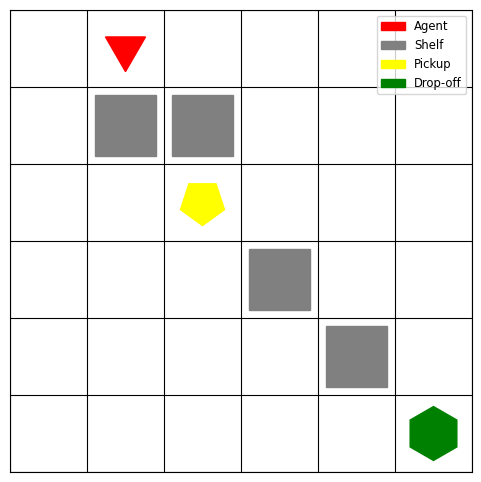

Step 2: Action: Down, Position: (0, 1, False), Reward: -1


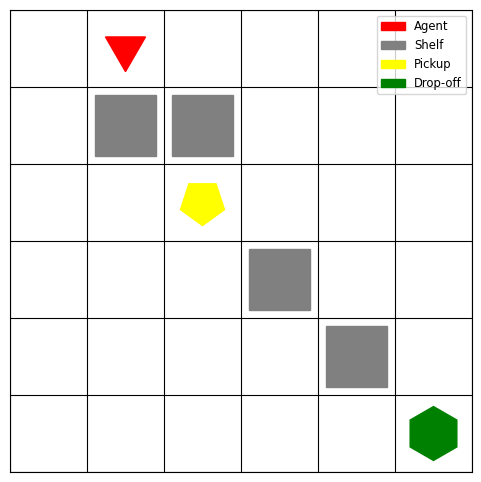

Step 3: Action: Left, Position: (0, 0, False), Reward: -1


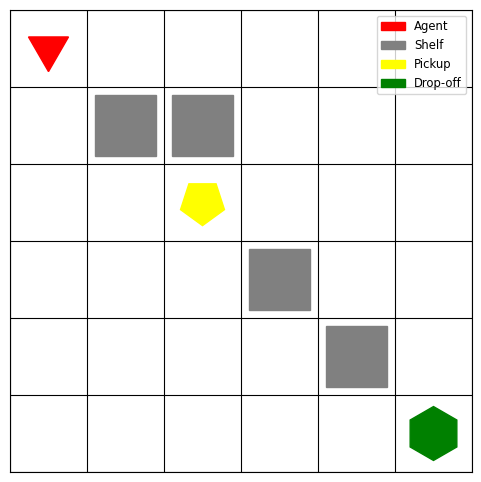

Step 4: Action: Up, Position: (0, 0, False), Reward: -1


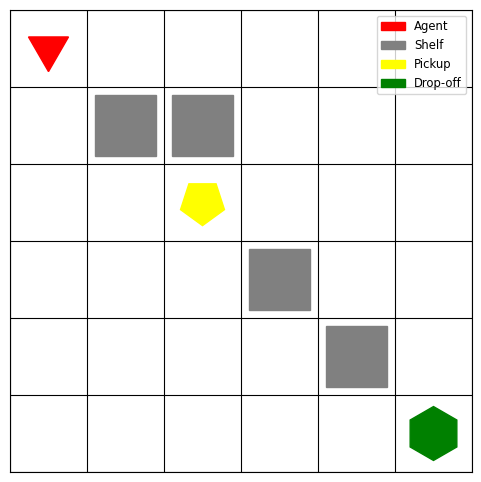

Step 5: Action: Right, Position: (0, 1, False), Reward: -1


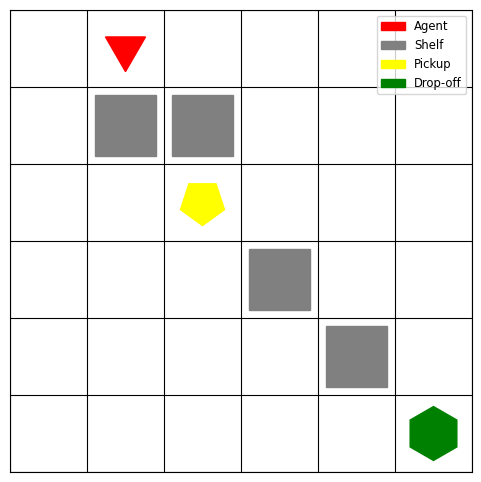

Step 6: Action: Up, Position: (0, 1, False), Reward: -1


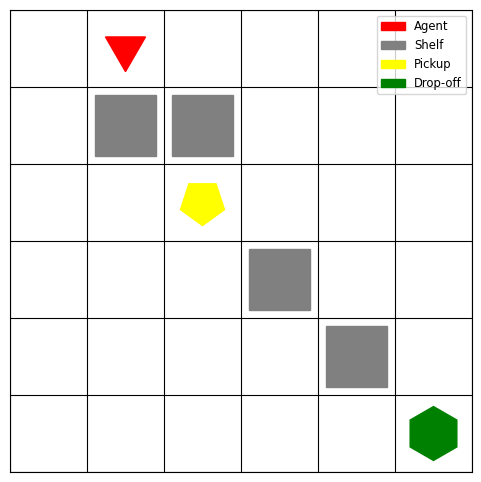

Step 7: Action: Down, Position: (0, 1, False), Reward: -1


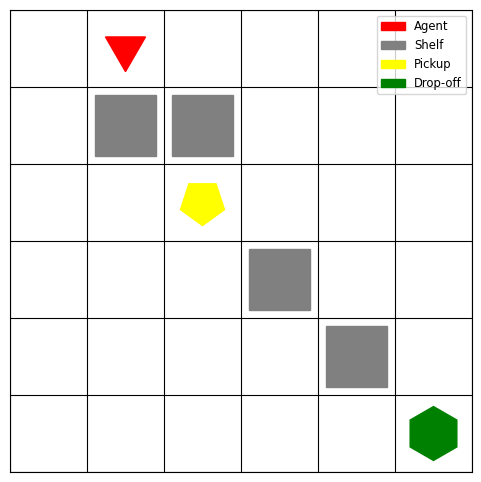

Step 8: Action: Right, Position: (0, 2, False), Reward: -1


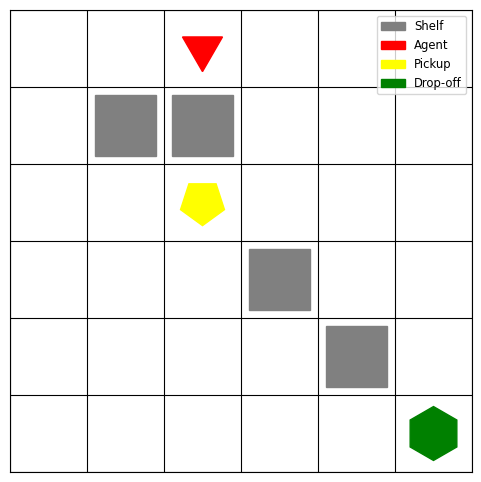

Step 9: Action: Up, Position: (0, 2, False), Reward: -1


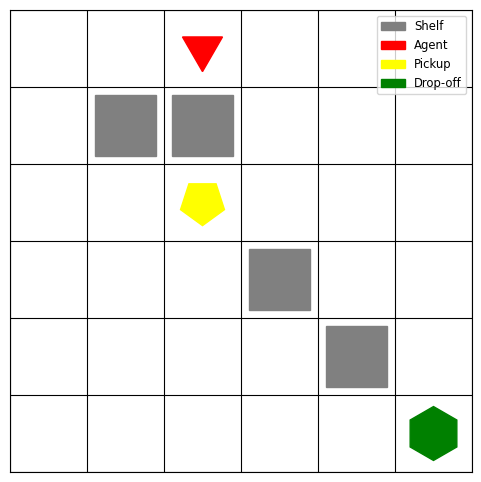

Step 10: Action: Pick-up, Position: (0, 2, False), Reward: -1


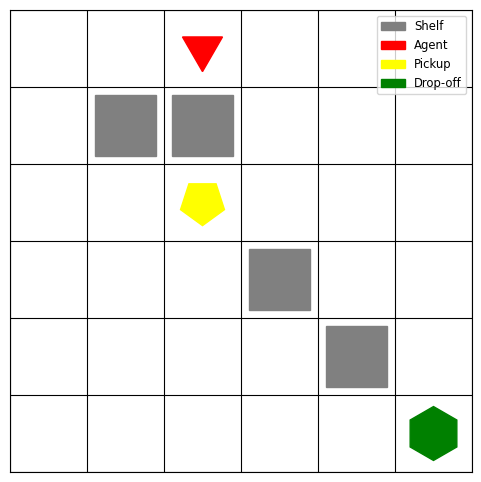


Training the SARSA agent...

Initial Q-Table (before training):
{}

Trained Q-Table:
{(0, 0, False): array([ 7.01484852e+01,  1.20195637e+03,  8.91575338e+01, -3.69579377e-01,
        7.83180530e+00,  6.15745838e+01]), (0, 0, True): array([-3.84814382, -3.893596  , -3.89998357, -3.87486122, -3.90306864,
       -4.00896909]), (0, 1, False): array([ -4.28197475,  -4.21459973, 132.2251733 ,  -3.94100017,
        -4.23012626,  -4.15950209]), (0, 1, True): array([-3.66906789, -3.76346021, -3.56150815, -3.48467144, -3.50934161,
       -3.54675581]), (0, 2, False): array([-3.29201895, -3.23226441, -3.9374469 , -2.93415678, -3.41164013,
       -3.21092716]), (0, 2, True): array([-3.41641833, -3.34005043, -3.43173881, -3.32249601, -3.30115351,
       -3.37749899]), (0, 3, False): array([-2.50668552, -0.91170533, -3.24397464, -2.46578659, -2.36176458,
       -2.39439739]), (0, 3, True): array([-3.16950196, -3.02781275, -2.99787808, -3.03349245, -2.98581197,
       -3.08330568]), (0, 4, False): 

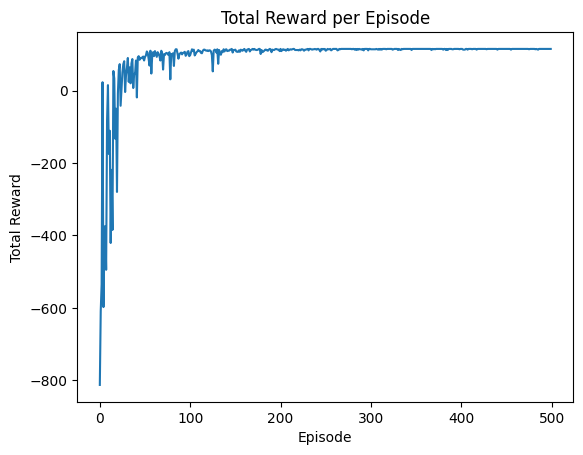

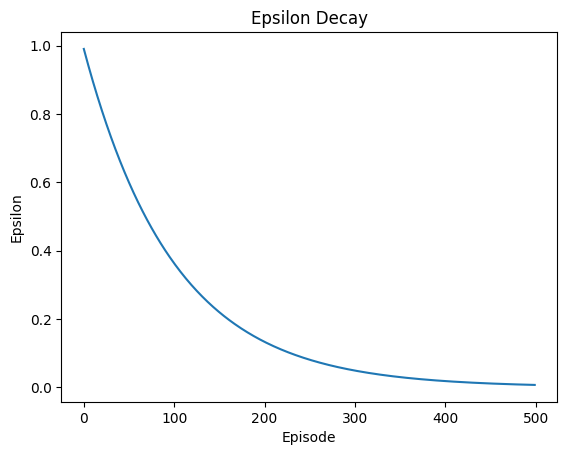


Evaluating the SARSA agent...


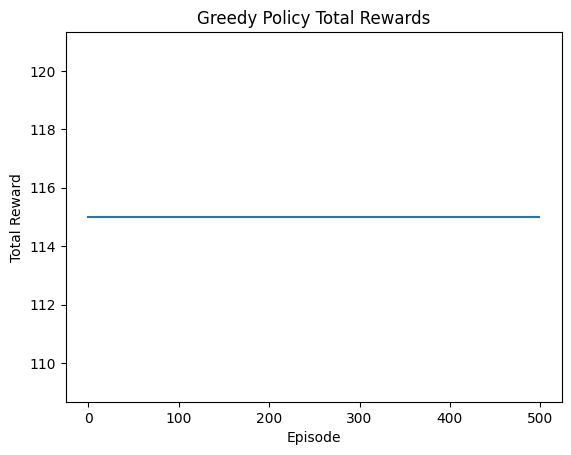

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.patches import RegularPolygon, Rectangle


class WarehouseRobotEnv:
    def __init__(self, grid_size=(6, 6)):
        self.grid_size = grid_size
        self.reset()

    def reset(self):
        self.agent_position = (0, 0)  # Starting position of the agent
        self.shelves = [(1, 1), (1, 2), (3, 3), (4, 4)]  # Shelves (obstacles)
        self.pickup_location = (2, 2)  # Pickup location
        self.dropoff_location = (5, 5)  # Drop-off location
        self.carrying_item = False  # Not carrying the item initially
        self.steps = 0
        return self._get_obs()

    def _get_obs(self):
        return self.agent_position + (self.carrying_item,)

    def render(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        for x in range(self.grid_size[1] + 1):
            ax.plot([x, x], [0, self.grid_size[0]], color="black", linewidth=0.8)
        for y in range(self.grid_size[0] + 1):
            ax.plot([0, self.grid_size[1]], [y, y], color="black", linewidth=0.8)
        for x in range(self.grid_size[1]):
            for y in range(self.grid_size[0]):
                if (y, x) in self.shelves:
                    ax.add_patch(Rectangle((x + 0.1, y + 0.1), 0.8, 0.8, color="gray", label="Shelf"))
                if (y, x) == self.pickup_location:
                    ax.add_patch(RegularPolygon((x + 0.5, y + 0.5), numVertices=5, radius=0.3, color="yellow", label="Pickup"))
                if (y, x) == self.dropoff_location:
                    ax.add_patch(RegularPolygon((x + 0.5, y + 0.5), numVertices=6, radius=0.35, color="green", label="Drop-off"))
                if (y, x) == self.agent_position:
                    ax.add_patch(RegularPolygon((x + 0.5, y + 0.5), numVertices=3, radius=0.3, color="red", label="Agent"))
        ax.set_xlim(0, self.grid_size[1])
        ax.set_ylim(0, self.grid_size[0])
        ax.set_aspect("equal")
        ax.invert_yaxis()
        ax.set_xticks([])
        ax.set_yticks([])
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc="upper right", fontsize="small", frameon=True)
        plt.show()

    def step(self, action):
        action_map = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
        if action in action_map:
            new_position = (self.agent_position[0] + action_map[action][0],
                            self.agent_position[1] + action_map[action][1])
            if 0 <= new_position[0] < self.grid_size[0] and 0 <= new_position[1] < self.grid_size[1]:
                if new_position not in self.shelves:
                    self.agent_position = new_position
        if action == 4 and self.agent_position == self.pickup_location and not self.carrying_item:
            self.carrying_item = True
            reward = 25
            return self._get_obs(), reward, False
        if action == 5 and self.agent_position == self.dropoff_location and self.carrying_item:
            reward = 100
            done = True
            return self._get_obs(), reward, done
        reward = -1
        done = False
        return self._get_obs(), reward, done


class SARSAAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.99):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay

        # Prepopulate the Q-table
        self.q_table = defaultdict(lambda: np.zeros(6))  # Action space size = 6
        for x in range(env.grid_size[0]):
            for y in range(env.grid_size[1]):
                for carrying in [False, True]:
                    state = (x, y, carrying)
                    self.q_table[state]  # Access to initialize

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, 6)  # Random action
        return np.argmax(self.q_table[state])

    def train(self, episodes=10):
        rewards_per_episode = []
        epsilon_values = []
        for episode in range(episodes):
            state = self.env.reset()
            action = self.choose_action(state)
            total_reward = 0
            while True:
                next_state, reward, done = self.env.step(action)
                next_action = self.choose_action(next_state)
                self.q_table[state][action] += self.alpha * (
                    reward + self.gamma * self.q_table[next_state][next_action] - self.q_table[state][action])
                state, action = next_state, next_action
                total_reward += reward
                if done:
                    break
            self.epsilon *= self.epsilon_decay
            rewards_per_episode.append(total_reward)
            epsilon_values.append(self.epsilon)
        return rewards_per_episode, epsilon_values

    def evaluate(self, episodes=10):
        rewards = []
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            while True:
                action = np.argmax(self.q_table[state])  # Greedy action
                state, reward, done = self.env.step(action)
                total_reward += reward
                if done:
                    break
            rewards.append(total_reward)
        return rewards


# Initialize environment and SARSA agent
env = WarehouseRobotEnv()
agent = SARSAAgent(env)

# Step 1: Print grid environment for 10 steps
print("\nRandom Actions (10 Steps):")
state = env.reset()
for step in range(10):
    action = np.random.choice([0, 1, 2, 3, 4, 5])  # Random action
    next_state, reward, done = env.step(action)
    action_name = ['Up', 'Down', 'Left', 'Right', 'Pick-up', 'Drop-off'][action]
    print(f"Step {step + 1}: Action: {action_name}, Position: {next_state}, Reward: {reward}")
    env.render()
    if done:
        print("Mission Completed!")
        break

# Step 2: Train the SARSA agent
print("\nTraining the SARSA agent...")
rewards_per_episode, epsilon_values = agent.train(episodes=500)

# Step 3: Print initial and trained Q-tables
print("\nInitial Q-Table (before training):")
print(dict(defaultdict(lambda: np.zeros(6))))  # Before training
print("\nTrained Q-Table:")
print(dict(agent.q_table))  # After training

# Step 4: Plot total reward per episode
plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.show()

# Step 5: Plot epsilon decay
plt.figure()
plt.plot(epsilon_values)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

# Step 6: Evaluate the SARSA agent
print("\nEvaluating the SARSA agent...")
greedy_rewards = agent.evaluate(episodes=500)

# Step 7: Plot greedy evaluation rewards
plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Greedy Policy Total Rewards")
plt.show()
